# Basic usage of the MICADO spectroscopy mode in ScopeSim

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"><br></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Set up ScopeSim and MICADO

The following ``import`` statements are needed to run ScopeSim.

The ``pkgs_path`` value can be changed to point to the folder where you are keeping the instrument packages. If you are using the default settings, then ScopeSim will download these packages to your working directory (where this notebook is) and move them into the ``inst_pkgs/`` subdirectory.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy import units as u

import scopesim as sim
from scopesim.source import source_templates as sim_tp

%matplotlib inline

If you have not do so already, please download the relevant instrument packages using the following code in a new cell:

    sim.download_packages(["Armazones", "ELT", "MORFEO", "MICADO"])
    
.. note:: In ScopeSim v0.5 both download_packages (new format) and download_package (old format) exist.

If we would like to keep the instrument packages in a separate directory, we can set the following config value:

    sim.rc.__config__["!SIM.file.local_packages_path"] = "path/to/packages"


## Basic on-sky source to observe

For the moment, we'll use only the most basic on-sky sources

In [3]:
src = sim_tp.empty_sky()
# src = sim_tp.star("K", 10)

## Set up MICADO for spectroscopy

We start off by importing all the configuration data with ``UserCommands``. 
Here we also specify which modes are to be used. 
To start with, we will use the 15 arcsec slit in the ``Spec_HK`` filter.

The ``set_modes`` parameter takes a list of two mode keywords: ``[<AO mode>, <slit>]``. 
- AO modes affect total system transmisison and which PSF file is used.
  - Possible values are ``SCAO``, ``MCAO``
- The slit modes difine the slit dimensions (and add the grating losses to the total transmission).
  The mode name reflects the dimensions of the slit in  [mas]:
  - Possible values are ``SPEC_3000x20``, ``SPEC_3000x50``, ``SPEC_15000x50``

Some possible combinations would be:

    set_modes=["SCAO", "SPEC_3000x20"]
    set_modes=["MCAO", "SPEC_3000x50"]
    set_modes=["SCAO", "SPEC_15000x50"]



In [ ]:
cmd = sim.UserCommands(use_instrument="MICADO", set_modes=["SCAO", "SPEC_15000x50"])

This notebook runs for a long time and requires more than 30 GB of RAM. It is possible to speed up the computation and reduce the memory consumption (at the cost of lower accuracy) by specifying the spectral bin width. Uncomment the following line if you prefer a faster but less accurate simulation:

In [ ]:
# cmd["!SIM.spectral.spectral_bin_width"] = 5e-4

In [4]:
micado = sim.OpticalTrain(cmd)

For testing purposes it maybe useful to only simulate a certain sub-window on the focal plane. 

If we want to simulate the full detector array, we need to exclude the ``detector_window`` effect, and include the ``full_detector_array`` effect. 

Naturally the execution time is dependent on whether we want to simulate only a small fraction of the focal plane, or the full thing.

In [5]:
USE_FULL_DETECTOR = True
micado["full_detector_array"].include = USE_FULL_DETECTOR
micado["detector_window"].include = not USE_FULL_DETECTOR

To check which detector configuration is currently used, we can print the table of effects with ``micado.effects``

In [6]:
micado.effects

element,name,class,included
str11,str27,str24,bool
armazones,skycalc_atmosphere,SkycalcTERCurve,True
ELT,telescope_reflection,SurfaceList,True
MICADO,micado_static_surfaces,SurfaceList,True
MICADO,micado_ncpas_psf,NonCommonPathAberration,True
MICADO,filter_wheel_1 : [Spec_HK],FilterWheel,True
MICADO,filter_wheel_2 : [open],FilterWheel,True
MICADO,pupil_wheel : [open],FilterWheel,True
MICADO_DET,full_detector_array,DetectorList,True
MICADO_DET,detector_window,DetectorWindow,False


## Observe the on-sky source with a 15000x50 slit in the Spec_HK filter

Running the simulation involves first ``observe()``ing the object, then ``readout()``ing the detectors.

    micado.observe(src)
    micado.readout()
    
``observe()`` does not produce any output, although it is possible to access (and save) the intermediate focal plane image.

``readout()`` returns a list of ``fits.HDUList`` object to the ipython session. 

By providing the ``filename`` keyword, the result can also be saved to disk: ``micado.readout(filename="spec_temp.fits")``

In [7]:
# Warning, this takes about 3 minutes to complete
micado.observe(src)

WARNING - Spectral trace footprint is outside FoV
WARNING - map_spectra_to_focal_plane: 9467 negative pixels
WARNING - map_spectra_to_focal_plane: 1869801 negative pixels
WARNING - map_spectra_to_focal_plane: 103838 negative pixels


Change ``dit`` and ``ndit`` to whatever we want the exposure time to be:

In [8]:
micado.cmds["!OBS.dit"] = 3600
micado.cmds["!OBS.ndit"] = 1

hdul = micado.readout()

### Checking the intermediate output

We can check the intermediate (noise-less) focal plane image by looking at the ``micado.image_planes[0]`` ``ImageHDU`` object:

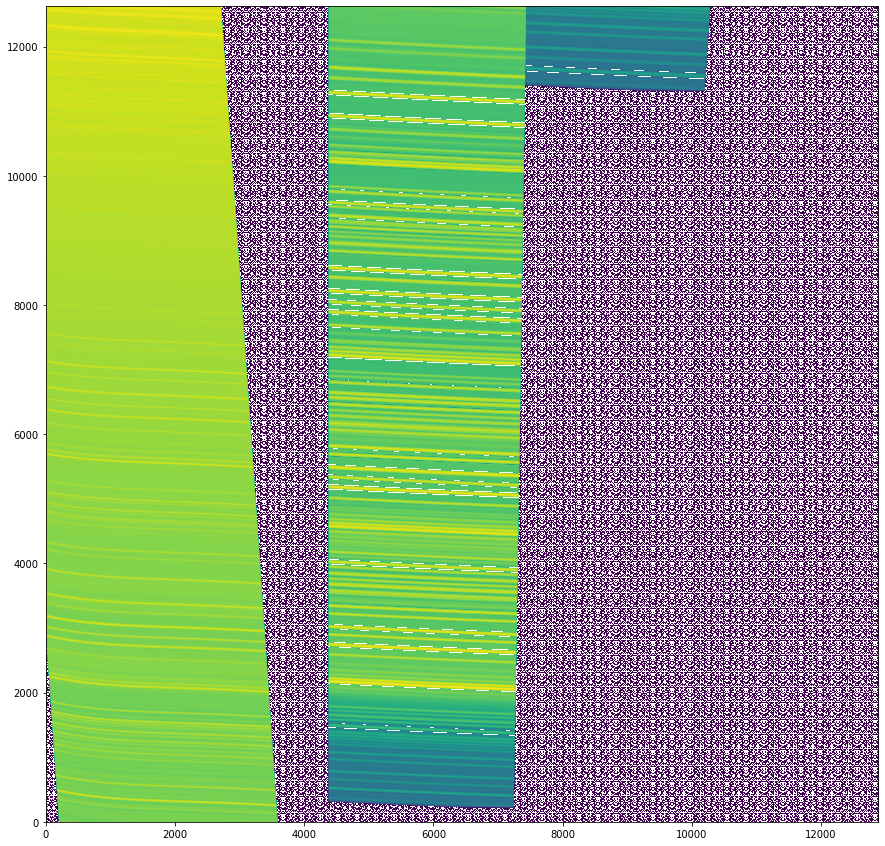

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(micado.image_planes[0].data, norm=LogNorm(), origin="lower")

### Checking the final output

Now we plot the noisy detector readouts

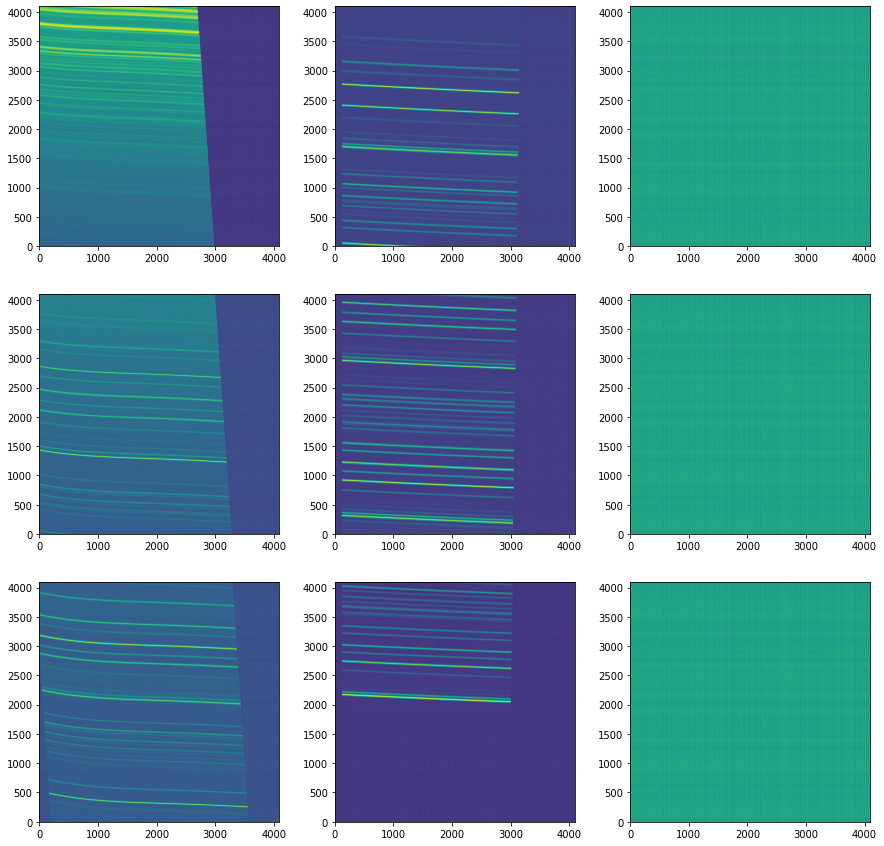

In [10]:
if USE_FULL_DETECTOR:
    plt.figure(figsize=(15,15))
    for i in range(1,10):
        plt.subplot(3,3,i)
        plt.imshow(hdul[0][i].data, norm=LogNorm(), origin="lower")

## Observe the on-sky source with a 3000x20 slit in the Spec_IJ filter

To change modes, we need to create a new model of MICADO.

The filter is set by default to the ``Spec_HK`` filter, located in filter wheel 1.

To change the filter to the ``"Spec_IJ"`` or ``"J"`` filter, we should use the setting: ``cmd["!OBS.filter_name_fw1"] = "Spec_IJ"``

In [17]:
cmd = sim.UserCommands(use_instrument="MICADO", set_modes=["SCAO", "SPEC_3000x20"])
cmd["!OBS.filter_name_fw1"] = "Spec_IJ"

micado = sim.OpticalTrain(cmd)

USE_FULL_DETECTOR = True
micado["full_detector_array"].include = USE_FULL_DETECTOR
micado["detector_window"].include = not USE_FULL_DETECTOR

In [18]:
micado.observe(src)

WARNING - map_spectra_to_focal_plane: 41691 negative pixels
WARNING - map_spectra_to_focal_plane: 39225 negative pixels
WARNING - map_spectra_to_focal_plane: 54627 negative pixels
WARNING - map_spectra_to_focal_plane: 12365 negative pixels


In [19]:
micado.cmds["!OBS.dit"] = 10 * 3600
hdul = micado.readout()

### Checking the intermediate output

We can check the intermediate (noise-less) focal plane image by looking at the ``micado.image_planes[0]`` ``ImageHDU`` object:

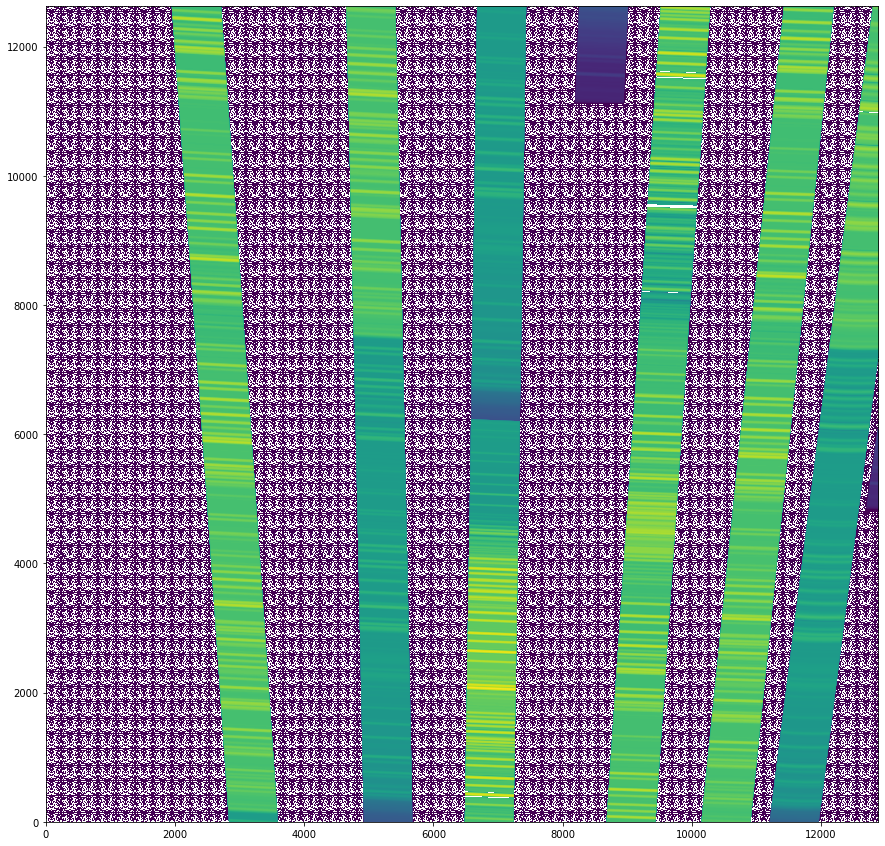

In [20]:
plt.figure(figsize=(15,15))
plt.imshow(micado.image_planes[0].data, norm=LogNorm(), origin="lower")

### Checking the final output

Now we plot the noisy detector readouts

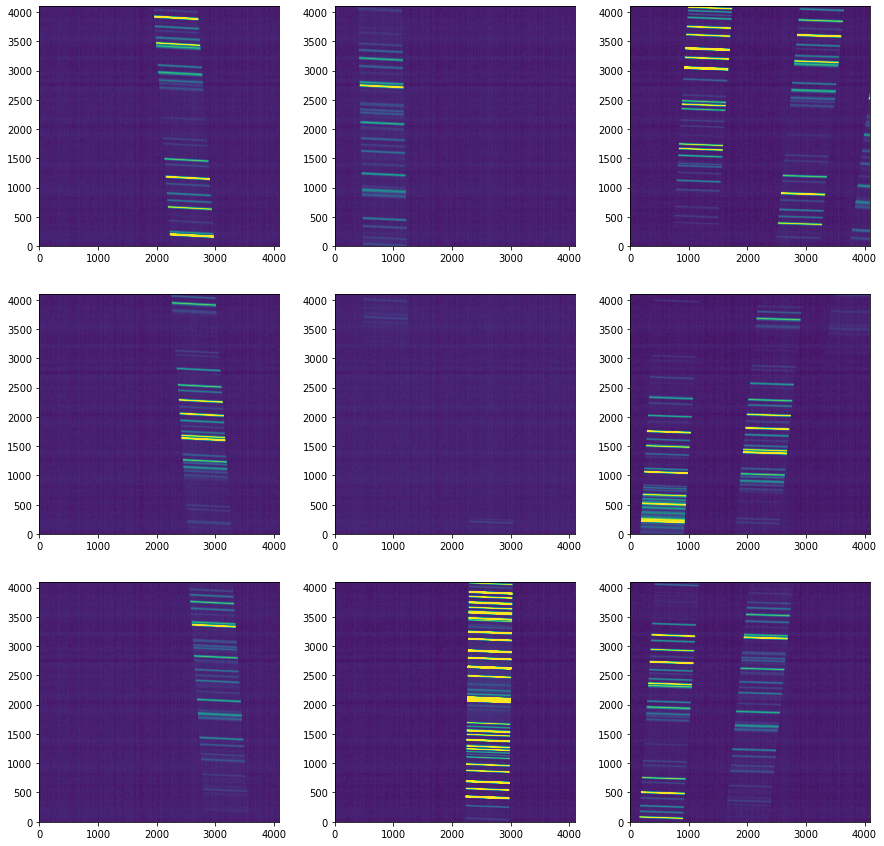

In [21]:
if USE_FULL_DETECTOR:
    plt.figure(figsize=(15,15))
    for i in range(1,10):
        plt.subplot(3,3,i)
        im = hdul[0][i].data
        plt.imshow(im, norm=LogNorm(vmin=0.99*np.median(im), vmax=1.1*np.median(im)), origin="lower")

## Saving to disk

All the returned objects are from the ``astropy.io.fits`` library, and can therefore be saved to disk in the usual manner:

In [16]:
micado.image_planes[0].hdu.writeto("intermediate_data.fits", overwrite=True)
hdul[0].writeto("detector_readout_data.fits", overwrite=True)